In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score

def generate_samples(n_samples, p, mu):
    """
    Generate n samples based on the provided data generating process.
    
    Parameters:
    - n: Number of samples.
    - p: Probability p(V=1).
    - mu: Dictionary containing values for mu{0,0}, mu{1,0}, mu{0,1}, and mu{1,1}.
    
    Returns:
    A tuple containing arrays for V, Y, X, and X* respectively.
    """
    
    # Generate V samples based on P(V=1) = p
    V = np.random.binomial(1, p, n_samples)
    
    # Given the V values, generate Y samples by using P(Y=1|V=0)=.2 and P(Y=1|V=1)=.9
    Y = np.random.binomial(1, np.where(V == 0, 0.2, 0.9))
    
    # Generate X samples based on values of Y and V
    # using P(X | Y = y, V = v) = N(μ{y,v}, 1)
    mu_X = np.array([mu[(y, v)] for y, v in zip(Y, V)])
    X = np.random.normal(mu_X, 1)
    
    # Generate X* samples based on values of Y
    # based on P(X∗ | Y = y) = N(μy, 0, 1)
    mu_X_star = np.array([mu[(y, 0)] for y in Y])
    X_star = np.random.normal(mu_X_star, 1)
    
    return V, Y, X, X_star

def bin_data(data, bins):
    bin_indices = np.digitize(data, bins)
    return bin_indices

def calculate_conditional_probabilities(Y, binned_X, bins, V):
    '''
    Calculate P(Y=1|bin) for binned data (for binned X, X* or (X,V))
    '''
    probabilities = {}
    if V is None:
        for b in range(1, len(bins)+1):
            y_given_bin = Y[binned_X == b] if len(Y[binned_X == b]) > 0 else 0
            probabilities[b] = np.mean(y_given_bin)
    
        return probabilities
    
    for b in range(1, len(bins)+1):
        y_given_bin_v1 =  Y[(binned_X == b) & (V==1)] if len(Y[(binned_X == b) & (V==1)]) > 0 else 0
        probabilities[10*b+2] = np.mean(y_given_bin_v1)
        y_given_bin_v0 = Y[(binned_X == b) & (V==0)] if len(Y[(binned_X == b) & (V==0)]) > 0 else 0
        probabilities[10*b+1] = np.mean(y_given_bin_v0)
    
    return probabilities
    
def fit_conditional_probability(X, Y , V=None, num_bins=100):
    '''
    returns a function that returns the conditional probability
    P(Y | X) if V is None, else P(Y | X,V)
    '''
    bins = np.linspace(min(X), max(X), num_bins)
    binned_X = bin_data(X, bins)
    conditional_probabilties = calculate_conditional_probabilities(Y, binned_X, bins, V)
    
    if V is None:
        def score(x):
            digitized = max(np.digitize(x, bins), 1)
            return conditional_probabilties[digitized]
    else:
        def score(x, v):
            digitized = max(np.digitize(x, bins), 1) 
            return conditional_probabilties[10*digitized+v+1]
    return score

def pdf(mu, std, width=8):
    x = np.linspace(mu - 0.5*width, mu + 0.5*width, 100)
    y = (1/(std * np.sqrt(2*np.pi))) * np.exp(-(x - mu)**2 / (2*std**2))
    return x,y 

def get_acc_auc(classifier, X, Y, V=None):
    if V is None:
        Y_pred = np.array([classifier(x) for x in X])
    else:
        Y_pred = np.array([classifier(x, v) for x, v in zip(X, V)])
    acc = accuracy_score(Y, Y_pred>0.5)
    auc = roc_auc_score(Y, Y_pred)
    return acc, auc

$\text{We generate the dataset containing} X, X^*, Y, V, \text{based on the data generating process}:$

- $P(V = 1) = p$
- $P(Y = 1 | V = 0) = 0.2$
- $P(Y = 1 | V = 1) = 0.9$
- $P (X | Y = y, V = v) = \mathcal{N}  (\mu_{y, v}, 1)$
- $P(X^∗ | Y = y) = N(\mu_{y, 0}, 1)$

$\text{with }p=0.1, \mu_{0,0}=2/3,  \mu_{0,1}=-2/3,  \mu_{1,0}=.8,  \mu_{1,1}=-.8$ 

In [3]:
mu_values = {(0,0): -2/3,  
             (1,0): 2/3,  
             (0,1): -0.8,  
             (1,1): 0.8}  
p=0.1
n_samples=20000
V, Y, X, X_star = generate_samples(n_samples, p, mu_values)

$\text{We fit }P(Y|X), P(Y|X*)\text{ and }P(Y|X, V)\text{ for our source dataset }(p=.1) \text{ by essentially counting the ratio of positive }Y\text{ for all bins of }X, X^* \text{ and } (X,V)\text{, respectively.}$

In [4]:
num_bins=100
P_Y_given_X = fit_conditional_probability(X, Y, num_bins=num_bins)
P_Y_given_X_star = fit_conditional_probability(X_star, Y, num_bins=num_bins)
P_Y_given_X_V = fit_conditional_probability(X, Y, V=V, num_bins=num_bins)

$\text{We generate new datasets for different } p \in (0.05, 0.95). \text{For every new target dataset, we evaluate the accuracy and auc using }P(Y|X), P(Y|X*)\text{ and }P(Y|X, V).$

In [5]:
p_y_x_accs = []
p_y_x_aucs = []
p_y_xs_accs = []
p_y_xs_aucs = []
p_y_x_v_accs = []
p_y_x_v_aucs = []
ps = np.linspace(0.05, 0.95, 12)
for p in ps:
    V, Y, X, X_star = generate_samples(n_samples, p, mu_values)
    p_y_x_acc, p_y_x_auc = get_acc_auc(P_Y_given_X, X, Y, V=None)
    p_y_xs_acc, p_y_xs_auc = get_acc_auc(P_Y_given_X_star, X_star, Y, V=None)
    p_y_x_v_acc, p_y_x_v_auc = get_acc_auc(P_Y_given_X_V, X, Y, V=V)
    p_y_x_accs.append(p_y_x_acc)
    p_y_x_aucs.append(p_y_x_auc)
    p_y_xs_accs.append(p_y_xs_acc)
    p_y_xs_aucs.append(p_y_xs_auc)
    p_y_x_v_accs.append(p_y_x_v_acc)
    p_y_x_v_aucs.append(p_y_x_v_auc)

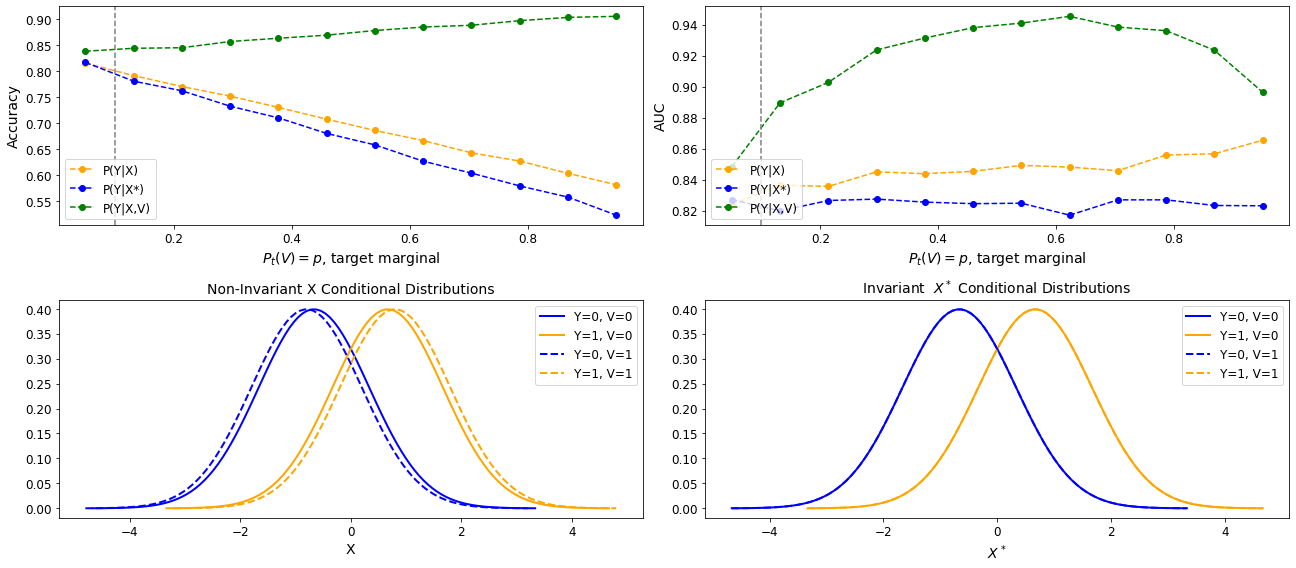

In [10]:
fontsize = 14
labelsize = 12

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18, 8))


ax[0,0].plot(ps, p_y_x_accs, 'o--', color='orange', label='P(Y|X)', markerfacecolor='orange')
ax[0,0].plot(ps, p_y_xs_accs, 'o--', color='blue', label='P(Y|X*)', markerfacecolor='blue')
ax[0,0].plot(ps, p_y_x_v_accs, 'o--', color='green', label='P(Y|X,V)', markerfacecolor='green')
ax[0,0].axvline(x=0.1, color='grey', linestyle='dashed')
ax[0,0].set_ylabel('Accuracy', fontsize=fontsize)
ax[0,0].set_xlabel('$P_t(V) = p$, target marginal', fontsize=fontsize)
ax[0,0].legend(loc='lower left', fontsize=labelsize)
ax[0,0].tick_params(axis='both', labelsize=labelsize)


ax[0,1].plot(ps, p_y_x_aucs, 'o--', color='orange', label='P(Y|X)', markerfacecolor='orange')
ax[0,1].plot(ps, p_y_xs_aucs, 'o--', color='blue', label='P(Y|X*)', markerfacecolor='blue')
ax[0,1].plot(ps, p_y_x_v_aucs, 'o--', color='green', label='P(Y|X,V)', markerfacecolor='green')
ax[0,1].axvline(x=0.1, color='grey', linestyle='dashed')
ax[0,1].set_ylabel('AUC', fontsize=fontsize)
ax[0,1].set_xlabel('$P_t(V) = p$, target marginal', fontsize=fontsize)
ax[0,1].legend(loc='lower left', fontsize=labelsize)
ax[0,1].tick_params(axis='both', labelsize=labelsize)


ax[1,0].plot(*pdf(mu_values[0, 0], 1), lw=2, color='blue', label="Y=0, V=0")
ax[1,0].plot(*pdf(mu_values[1, 0], 1), lw=2, color='orange', label="Y=1, V=0")
ax[1,0].plot(*pdf(mu_values[0, 1], 1), lw=2, linestyle='dashed', color='blue', label="Y=0, V=1")
ax[1,0].plot(*pdf(mu_values[1, 1], 1), lw=2, linestyle='dashed', color='orange', label="Y=1, V=1")
ax[1,0].set_title("Non-Invariant X Conditional Distributions", fontsize=fontsize)
ax[1,0].set_xlabel("X", fontsize=fontsize)
ax[1,0].legend(fontsize=labelsize)
ax[1,0].tick_params(axis='both', labelsize=labelsize)


ax[1,1].plot(*pdf(mu_values[0, 0], 1), lw=2, color='blue', label="Y=0, V=0")
ax[1,1].plot(*pdf(mu_values[1, 0], 1), lw=2, color='orange', label="Y=1, V=0")
ax[1,1].plot(*pdf(mu_values[0, 0], 1), lw=2, linestyle='dashed', color='blue', label="Y=0, V=1")
ax[1,1].plot(*pdf(mu_values[1, 0], 1), lw=2, linestyle='dashed', color='orange', label="Y=1, V=1")
ax[1,1].set_title("Invariant  $X^*$ Conditional Distributions", fontsize=fontsize)
ax[1,1].set_xlabel("$X^*$", fontsize=fontsize)
ax[1,1].legend(fontsize=labelsize)
ax[1,1].tick_params(axis='both', labelsize=labelsize)

plt.tight_layout()
plt.show()